In [1]:
library(ArchR)
library(parallel)
library(biosignals)
set.seed(1)
addArchRThreads(threads = 16) 

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats

In [2]:
addArchRGenome("hg38")

Setting default genome to Hg38.



# Input data

In [3]:
root = '/Genomics/pritykinlab/zzhao/scATAC/motif_regression_prelim'
scatac_input = 'data/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz'
scatac_input = paste(root, scatac_input, sep="/")
out_dir = "coassay_processed/"
out_dir = paste(root, out_dir, sep="/")
archr_out = "archR_output"
archr_out = paste(root, archr_out, sep="/")

In [4]:
archr_out

[1] "/Genomics/pritykinlab/zzhao/scATAC/motif_regression_prelim/archR_output"

# create arrow files and preprocess data

In [5]:
# Create Arrow files, filter

ArrowFiles <- createArrowFiles(
  inputFiles = c(scatac_input),
  sampleNames = c("coassay_analysis"),
  minTSS = 10, #Dont set this too high because you can always increase later
  minFrags = 2500, # both TSS and Frags have different parameter names from the tutorial, using minFrags and minTSS instead.
  addTileMat = TRUE,
  addGeneScoreMat = TRUE,
  force = TRUE
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

ArchR logging to : ArchRLogs/ArchR-createArrows-4e3227dd473db-Date-2022-06-01_Time-12-00-14.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2022-06-01 12:00:14 : Batch Execution w/ safelapply!, 0 mins elapsed.

(coassay_analysis : 1 of 1) Checking if completed file exists!

2022-06-01 12:00:14 : (coassay_analysis : 1 of 1) Arrow Exists! Overriding since force = TRUE!, 0.001 mins elapsed.

(coassay_analysis : 1 of 1) Determining Arrow Method to use!

2022-06-01 12:00:14 : (coassay_analysis : 1 of 1) Reading In Fragments from inputFiles (readMethod = tabix), 0.009 mins elapsed.

2022-06-01 12:00:14 : (coassay_analysis : 1 of 1) Tabix Bed To Temporary File, 0.009 mins elapsed.

2022-06-01 12:02:29 : (coassay_analysis : 1 of 1) Successful creation of Temporary File, 2.248 mins elapsed.

2022-06-01 12:02:29 : (coassay_analysis : 1 of 1) Creating Ar

In [6]:
ArrowFiles

[1] "coassay_analysis.arrow"

In [7]:
# Inferring doublets

doubScores <- addDoubletScores(
  input = ArrowFiles,
  k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
  knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search.
  LSIMethod = 1
)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-4e3223de7858a-Date-2022-06-01_Time-12-13-09.log
If there is an issue, please report to github with logFile!

2022-06-01 12:13:10 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-06-01 12:13:10 : coassay_analysis (1 of 1) :  Computing Doublet Statistics, 0 mins elapsed.

coassay_analysis (1 of 1) : UMAP Projection R^2 = 0.99925

coassay_analysis (1 of 1) : UMAP Projection R^2 = 0.99925

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
ArchR logging successful to : ArchRLogs/ArchR-addDoubletScores-4e3223de7858a-Date-2022-06-01_Time-12-13-09.log



In [8]:
# Creating an ArchRProject 

scatac.object <- ArchRProject(
  ArrowFiles = ArrowFiles,
  outputDirectory = archr_out,
  copyArrows = TRUE                                                    
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...

1 


Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 


Getting Cell Metadata...

1 


Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--'

In [9]:
getAvailableMatrices(scatac.object)

[1] "GeneScoreMatrix" "TileMatrix"

In [10]:
# filter doublets

scatac.object <- filterDoublets(ArchRProj = scatac.object)

Filtering 1228 cells from ArchRProject!

	coassay_analysis : 1228 of 11086 (11.1%)



# clustering

In [11]:
# LSI based on TileMatrix (reduce dimensionality)

scatac.object <- addIterativeLSI(ArchRProj = scatac.object, useMatrix = "TileMatrix", name = "IterativeLSI")

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-4e32270792ebb-Date-2022-06-01_Time-12-21-13.log
If there is an issue, please report to github with logFile!

2022-06-01 12:21:13 : Computing Total Across All Features, 0.001 mins elapsed.

2022-06-01 12:21:14 : Computing Top Features, 0.018 mins elapsed.

###########
2022-06-01 12:21:16 : Running LSI (1 of 2) on Top Features, 0.049 mins elapsed.
###########

2022-06-01 12:21:16 : Creating Partial Matrix, 0.049 mins elapsed.

2022-06-01 12:22:03 : Computing LSI, 0.837 mins elapsed.

2022-06-01 12:24:46 : Identifying Clusters, 3.551 mins elapsed.

2022-06-01 12:24:59 : Identified 6 Clusters, 3.764 mins elapsed.

2022-06-01 12:24:59 : Saving LSI Iteration, 3.764 mins elapsed.

2022-06-01 12:25:17 : Creating Cluster Matrix on the total Group Features, 4.056 mins elapsed.

2022-06-01 12:25:33 : Computing Variable Features, 4.323 mins elapsed.

###########
2022-06-01 12:25:33 : Running LSI (2 of 2) on Variable Features, 4

In [12]:
# call clusters based on Seurat’s graph clustering

scatac.object <- addClusters(input = scatac.object, reducedDims = "IterativeLSI")

ArchR logging to : ArchRLogs/ArchR-addClusters-4e32221878674-Date-2022-06-01_Time-12-27-58.log
If there is an issue, please report to github with logFile!

2022-06-01 12:27:59 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.002 mins elapsed.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9858
Number of edges: 386905

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8878
Number of communities: 17
Elapsed time: 0 seconds


2022-06-01 12:28:10 : Testing Biased Clusters, 0.193 mins elapsed.

2022-06-01 12:28:11 : Identified Biased Clusters (n = 1), set filterBias = TRUE to re-assign these cells: , 0.197 mins elapsed.

Biased Clusters : 
Cluster10 


2022-06-01 12:28:11 : Testing Outlier Clusters, 0.197 mins elapsed.

2022-06-01 12:28:11 : Assigning Cluster Names to 17 Clusters, 0.197 mins elapsed.

2022-06-01 12:28:11 : Finished addClusters, 0.198 mins elapsed.



In [13]:
# UMAP and cluster

scatac.object <- addUMAP(ArchRProj = scatac.object, reducedDims = "IterativeLSI")

12:28:11 UMAP embedding parameters a = 0.7669 b = 1.223

12:28:11 Read 9858 rows and found 30 numeric columns

12:28:11 Using Annoy for neighbor search, n_neighbors = 40

12:28:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:28:12 Writing NN index file to temp file /tmp/RtmpimOLmE/file4e3227cbea61e

12:28:12 Searching Annoy index using 48 threads, search_k = 4000

12:28:12 Annoy recall = 100%

12:28:13 Commencing smooth kNN distance calibration using 48 threads

12:28:14 Initializing from normalized Laplacian + noise

12:28:15 Commencing optimization for 500 epochs, with 567412 positive edges

12:28:48 Optimization finished

12:28:48 Creating temp model dir /tmp/RtmpimOLmE/dir4e322318396aa

12:28:48 Creating dir /tmp/RtmpimOLmE/dir4e322318396aa

12:28:49 Changing

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-4e3222f3f302d-Date-2022-06-01_Time-12-28-50.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-4e3222f3f302d-Date-2022-06-01_Time-12-28-50.log



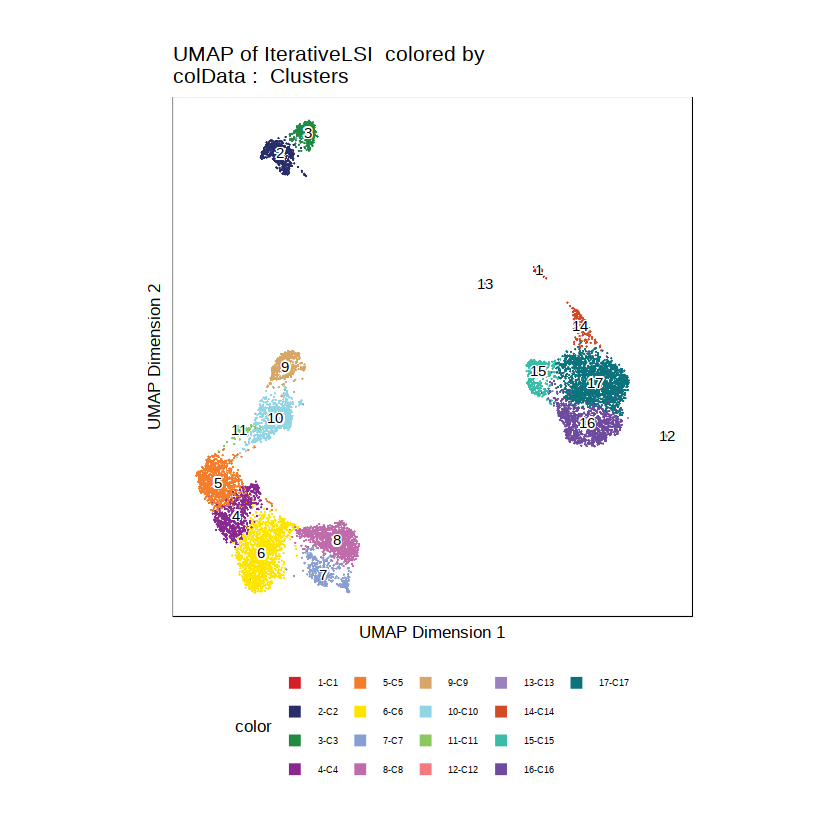

In [14]:
# plot clusters

pp <- plotEmbedding(ArchRProj = scatac.object, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")
pp

In [15]:
# save figures
plotPDF(pp, name = "Plot-UMAP-Cell-Clusters.pdf",
        ArchRProj = scatac.object, addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!



# Assigning Clusters with Gene Scores

In [16]:
# add imputation weights using MAGIC to help smooth the dropout noise in our gene scores.

scatac.object <- addImputeWeights(scatac.object)

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-4e32227c63ac7-Date-2022-06-01_Time-12-28-56.log
If there is an issue, please report to github with logFile!

2022-06-01 12:28:56 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.

Warning message in sprintf("Completed Getting Magic Weights!", round(object.size(weightList)/10^9, :
“one argument not used by format 'Completed Getting Magic Weights!'”


In [17]:
# define marker genes and make plots

# markerGenes  <- c(
#     "CD34",  #Early Progenitor
#     "GATA1", #Erythroid
#     "PAX5", "MS4A1", "MME", #B-Cell Trajectory
#     "CD14", "MPO", #Monocytes
#     "CD3D", "CD8A"#TCells
#   )
markerGenes  <- c(
    "CD4",  # helper T cell
    "CD8A",  # cytotoxic T cell 
    "CD79A",# B cell
    "FOXP3", # regulatory T cell
    "XCL1", # memory and naïve T cells
    "GZMB", # CD8 effectors (cytotoxic T cells)
    "LAG3", "PDCD1", "ID3" # exhaustion
  )

p <- plotEmbedding(
    ArchRProj = scatac.object, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes, 
    embedding = "UMAP",
    imputeWeights = getImputeWeights(scatac.object)
)

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-4e3223c6c5e7b-Date-2022-06-01_Time-12-29-06.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2022-06-01 12:29:06 : 

1 


Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 
8 
9 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-4e3223c6c5e7b-Date-2022-06-01_Time-12-29-06.log



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


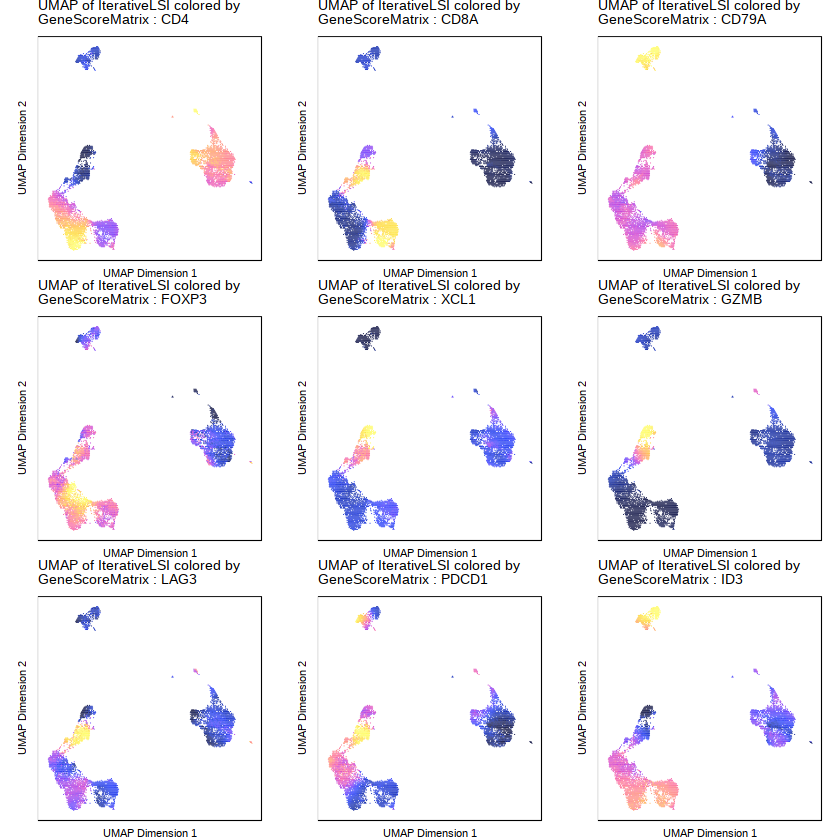

In [18]:
#Rearrange for grid plotting
p2 <- lapply(p, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p2))

* CD4: 11; 4, 10; 6, 5, 3, 9 (helper T cell)
* CD8A: 16, 17, 13, 14; 12 (killer T cell)
* CD79A: 7, 8; ; 9, 10, 11, 12, 13, 14, 15, 16, 17 (B cell)
* FOXP3: 10, 11; 9, 13, ... (regulatory T cell)
* XCL1: 15; 16 (memory and naïve T cells)
* GZMB: 15; 16 -- CD8 effectors (cytotoxic T cells)
* LAG3 -- 16, PDCD1 -- 16; 7, 9, ID3: 8, 7, 10-14; 9(exhaustion)

In [19]:
plotPDF(plotList = p2, 
    name = "Plot-UMAP-Marker-Genes-W-Imputation.pdf", 
    ArchRProj = scatac.object, 
    addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!



# Visualizing Genome Browser Tracks

In [20]:
# browse the local chromatin accessibility at these marker genes on a per cluster basis with genome browser tracks

p <- plotBrowserTrack(
    ArchRProj = scatac.object, 
    groupBy = "Clusters", 
    geneSymbol = markerGenes, 
    upstream = 50000,
    downstream = 50000
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-4e322840810d-Date-2022-06-01_Time-12-29-27.log
If there is an issue, please report to github with logFile!

2022-06-01 12:29:28 : Validating Region, 0.006 mins elapsed.



GRanges object with 9 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]    chr12     6786858-6820808      + |         920         CD4
  [2]     chr2   86784610-86808396      - |         925        CD8A
  [3]    chr19   41877120-41881372      + |         973       CD79A
  [4]     chrX   49250436-49264826      - |       50943       FOXP3
  [5]     chr1 168576473-168582077      + |        6375        XCL1
  [6]    chr14   24630954-24634267      - |        3002        GZMB
  [7]    chr12     6772512-6778455      + |        3902        LAG3
  [8]     chr2 241849881-241858908      - |        5133       PDCD1
  [9]     chr1   23557918-23559794      - |        3399         ID3
  -------
  seqinfo: 24 sequences from hg38 genome


2022-06-01 12:29:28 : Adding Bulk Tracks (1 of 9), 0.008 mins elapsed.

Getting Region From Arrow Files 1 of 1

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-06-01 12:29:31 : Adding Gene Tracks (1 of 9), 0.058 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-06-01 12:29:31 : Plotting, 0.063 mins elapsed.

2022-06-01 12:29:34 : Adding Bulk Tracks (2 of 9), 0.113 mins elapsed.

Getting Region From Arrow Files 1 of 1

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-06-01 12:29:38 : Adding Gene Tracks (2 of 9), 0.185 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-06-01 12:29:39 : Plotting, 0.19 mins elapsed.

2022-06-01 12:29:41 : Adding Bulk Tracks (3 of 9), 0.226 mins elapsed.

Getting Region From Arrow F

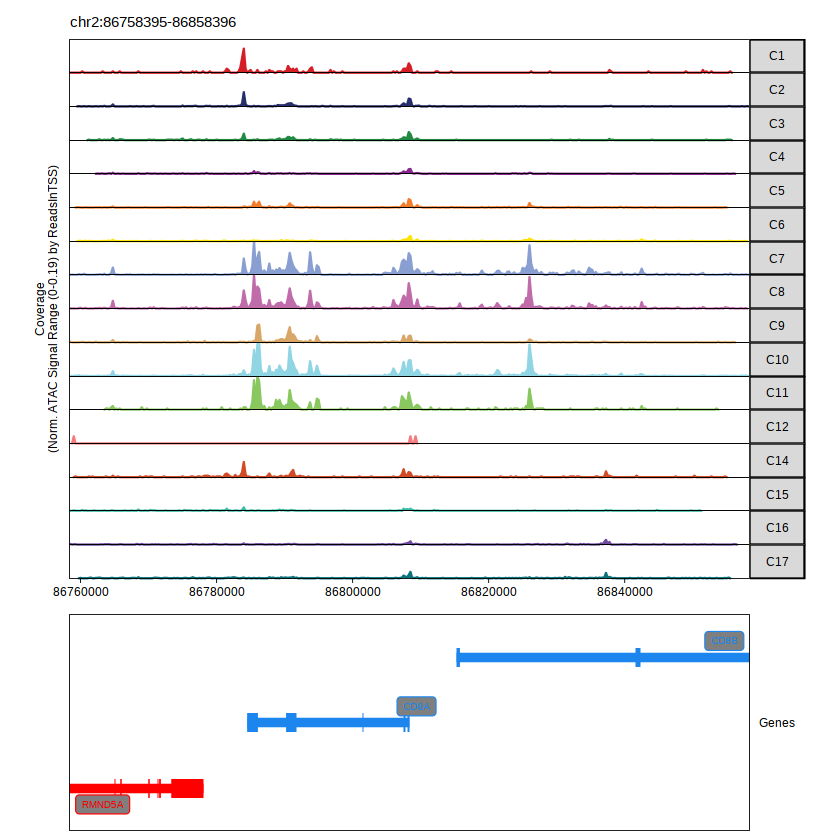

In [21]:
# plot CD14 gene accessibility at different clusters

grid::grid.newpage()
grid::grid.draw(p$CD8A)

In [22]:
plotPDF(plotList = p, 
    name = "Plot-Tracks-Marker-Genes.pdf", 
    ArchRProj = scatac.object, 
    addDOC = FALSE, width = 5, height = 5)

Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


In [23]:
saveArchRProject(ArchRProj = scatac.object, outputDirectory = archr_out, load = FALSE)

Saving ArchRProject...



# peak calling

In [24]:
# scatac.object <- loadArchRProject(path = archr_out)

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [25]:
pathToMacs2 <- '/Genomics/grid/users/zz5084/anaconda3/envs/r/bin/macs2'
pathToMacs2

[1] "/Genomics/grid/users/zz5084/anaconda3/envs/r/bin/macs2"

In [26]:
scatac.object <- addGroupCoverages(scatac.object, groupBy = "Clusters") 

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-4e322542c15c7-Date-2022-06-01_Time-12-30-27.log
If there is an issue, please report to github with logFile!

C1 (1 of 17) : CellGroups N = 2

C2 (2 of 17) : CellGroups N = 2

C3 (3 of 17) : CellGroups N = 2

C4 (4 of 17) : CellGroups N = 2

C5 (5 of 17) : CellGroups N = 2

C6 (6 of 17) : CellGroups N = 2

C7 (7 of 17) : CellGroups N = 2

C8 (8 of 17) : CellGroups N = 2

C9 (9 of 17) : CellGroups N = 2

C10 (10 of 17) : CellGroups N = 2

C11 (11 of 17) : CellGroups N = 2

C12 (12 of 17) : CellGroups N = 2

C13 (13 of 17) : CellGroups N = 2

C14 (14 of 17) : CellGroups N = 2

C15 (15 of 17) : CellGroups N = 2

C16 (16 of 17) : CellGroups N = 2

C17 (17 of 17) : CellGroups N = 2

2022-06-01 12:30:29 : Creating Coverage Files!, 0.029 mins elapsed.

2022-06-01 12:30:29 : Batch Execution w/ safelapply!, 0.029 mins elapsed.

2022-06-01 12:32:59 : Adding Kmer Bias to Coverage Files!, 2.522 mins elapsed.

Completed Kmer Bias Calculation

Addi

In [27]:
?addReproduciblePeakSet()

In [28]:
scatac.object <- addReproduciblePeakSet(
    ArchRProj = scatac.object, 
    groupBy = "Clusters", 
    pathToMacs2 = pathToMacs2
)

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-4e3221d2ce389-Date-2022-06-01_Time-12-34-54.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2022-06-01 12:34:54 : Peak Calling Parameters!, 0.011 mins elapsed.



    Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
C1     C1     95         95           2   40   55    47500
C2     C2    421        421           2   40  381   150000
C3     C3    318        318           2   40  278   150000
C4     C4    657        540           2   40  500   150000
C5     C5    865        540           2   40  500   150000
C6     C6   1432        540           2   40  500   150000
C7     C7    373        373           2   40  333   150000
C8     C8   1064        540           2   40  500   150000
C9     C9    435        435           2   40  395   150000
C10   C10    666        540           2   40  500   150000
C11   C11    103        103           2   40   63    51500
C12   C12     27         27           2   18   19    13500
C13   C13     14         14           2   11   11     7000
C14   C14    168        168           2   40  128    84000
C15   C15    408        408           2   40  368   150000
C16   C16   1029        540           2   40  500   1500

2022-06-01 12:34:54 : Batching Peak Calls!, 0.011 mins elapsed.

2022-06-01 12:34:54 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-06-01 12:37:22 : Identifying Reproducible Peaks!, 2.467 mins elapsed.

2022-06-01 12:37:29 : Creating Union Peak Set!, 2.586 mins elapsed.

Converged after 10 iterations!

Plotting Ggplot!

2022-06-01 12:37:37 : Finished Creating Union Peak Set (164312)!, 2.725 mins elapsed.



In [29]:
head(getPeakSet(scatac.object))

GRanges object with 6 ranges and 13 metadata columns:
      seqnames        ranges strand |     score replicateScoreQuantile
         <Rle>     <IRanges>  <Rle> | <numeric>              <numeric>
  C16     chr1 816086-816586      * |   4.81795                  0.422
  C14     chr1 817087-817587      * |  69.33960                  0.882
  C14     chr1 820635-821135      * |   6.20585                  0.382
  C17     chr1 822310-822810      * |   3.38626                  0.210
  C16     chr1 826526-827026      * |   8.69690                  0.363
  C16     chr1 827307-827807      * |  52.29740                  0.950
      groupScoreQuantile Reproducibility GroupReplicate distToGeneStart
               <numeric>       <numeric>    <character>       <integer>
  C16              0.120               2     C16._.Rep2            1034
  C14              0.783               2     C14._.Rep1              33
  C14              0.100               2     C14._.Rep1            3513
  C17             

In [30]:
saveArchRProject(ArchRProj = scatac.object, outputDirectory = archr_out, load = FALSE)

Saving ArchRProject...



In [33]:
scatac_peak <- addPeakMatrix(scatac.object)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-4e32276e17232-Date-2022-06-01_Time-12-49-12.log
If there is an issue, please report to github with logFile!

2022-06-01 12:49:13 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-06-01 12:49:13 : Adding coassay_analysis to PeakMatrix for Chr (1 of 23)!, 0.011 mins elapsed.

2022-06-01 12:49:37 : Adding coassay_analysis to PeakMatrix for Chr (2 of 23)!, 0.412 mins elapsed.

2022-06-01 12:49:53 : Adding coassay_analysis to PeakMatrix for Chr (3 of 23)!, 0.667 mins elapsed.

2022-06-01 12:50:04 : Adding coassay_analysis to PeakMatrix for Chr (4 of 23)!, 0.847 mins elapsed.

2022-06-01 12:50:10 : Adding coassay_analysis to PeakMatrix for Chr (5 of 23)!, 0.958 mins elapsed.

2022-06-01 12:50:18 : Adding coassay_analysis to PeakMatrix for Chr (6 of 23)!, 1.089 mins elapsed.

2022-06-01 12:50:28 : Adding coassay_analysis to PeakMatrix for Chr (7 of 23)!, 1.258 mins elapsed.

2022-06-01 12:50:37 : Adding coassay_analysis to PeakMatrix for 

In [34]:
getAvailableMatrices(scatac_peak)

[1] "GeneScoreMatrix" "PeakMatrix"      "TileMatrix"

In [39]:
# peaks <- getMatrixFromProject(scatac.object, useMatrix='PeakMatrix')
# peakmat <- toMatrix(peaks)
# writeMM(peakmat, paste(archr_out, "PBMC_peak_cell_matrix.mtx", sep="/"))

In [40]:
# write.table(getPeakSet(scatac.object), paste(archr_out, "PBMC_peaks.txt", sep="/"), append = FALSE, sep = "\t", quote = FALSE, row.names = FALSE)
# write.table(colData(peaks), paste(archr_out, "PBMC_cellnames_info.txt", sep="/"), append = FALSE, sep = "\t", quote = FALSE)

# lsi_object = getReducedDims(
#   ArchRProj = scatac.object,
#   reducedDims = "IterativeLSI",
#   returnMatrix = TRUE,
#   dimsToUse = NULL,
#   scaleDims = NULL,
#   corCutOff = 0.75
# )

# write.table(lsi_object, paste(archr_out, "PBMC_Iterative_LSI.txt", sep="/"), append = FALSE, sep = "\t", quote = FALSE)